<a href="https://colab.research.google.com/github/christopherfr/trabajofinalml/blob/walter_prueba/Trabajo_final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos el dataset

In [40]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', header = 1)
data.drop('ID', axis = 1, inplace = True) # Nos deshacemos de la columna ID ya que no es importante

In [41]:
data.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


#Información acerca del dataset

Lista de variables por tipo

In [42]:
print('Variables categóricas nominales:')
print('  - SEX\n  - MARRIAGE\n  - EDUCATION') # EDUCATION no la tratamos como ordinal porque no se conoce qué incluye la categoría 'others'
print('Variables discretas:')
print('  - PAY_0\n  - PAY_2\n  - PAY_3\n  - PAY_4\n  - PAY_5\n  - PAY_6')
print('Variables continuas:')
print('  - AGE\n  - BILL_AMT1\n  - BILL_AMT2\n  - BILL_AMT3\n  - BILL_AMT4\n  - BILL_AMT5\n  - BILL_AMT6\n  - PAY_AMT1\n  - PAY_AMT2\n  - PAY_AMT3\n  - PAY_AMT4\n  - PAY_AMT5\n  - PAY_AMT6')
print('Variable target: default payment next month')

Variables categóricas nominales:
  - SEX
  - MARRIAGE
  - EDUCATION
Variables discretas:
  - PAY_0
  - PAY_2
  - PAY_3
  - PAY_4
  - PAY_5
  - PAY_6
Variables continuas:
  - AGE
  - BILL_AMT1
  - BILL_AMT2
  - BILL_AMT3
  - BILL_AMT4
  - BILL_AMT5
  - BILL_AMT6
  - PAY_AMT1
  - PAY_AMT2
  - PAY_AMT3
  - PAY_AMT4
  - PAY_AMT5
  - PAY_AMT6
Variable target: default payment next month


Número de muestras en los conjuntos de entrenamiento y prueba. En caso aplique, número de muestras por clase.

In [43]:
m = len(data)
ratio_test = 0.1
q_test = int(round(m * ratio_test, 0))
q_train = m - q_test
print('Se tienen {} muestras en total. Un {}% se usará para la evaluación, es decir,\nse entrenarán los modelos con {} registros y con {} se evaluarán.'.format(m, ratio_test * 100, q_train, q_test))

import numpy as np
target_agrupado = data.groupby('default payment next month')['default payment next month'].count()
q_clases_target = np.array(target_agrupado.sort_index(ascending = True))
p_clases_target = q_clases_target / np.sum(q_clases_target) * 100
print('Para el entrenamiento un {}% será de la clase 0 y el otro {}% de la clase 1 (default).'.format(round(p_clases_target[0],1), round(p_clases_target[1],1)))

Se tienen 30000 muestras en total. Un 10.0% se usará para la evaluación, es decir,
se entrenarán los modelos con 27000 registros y con 3000 se evaluarán.
Para el entrenamiento un 77.9% será de la clase 0 y el otro 22.1% de la clase 1 (default).


Estadística descriptiva y visualización de los datos

Descripción de las variables

In [44]:
data.iloc[:,:-1].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


Descripción de la variable sexo

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable sexo. Donde:
*   1 = Male
*   2 = Female

In [45]:
enc = {1:'male', 2:'female'}
data.iloc[:,1].replace(enc).value_counts()

female    18112
male      11888
Name: SEX, dtype: int64

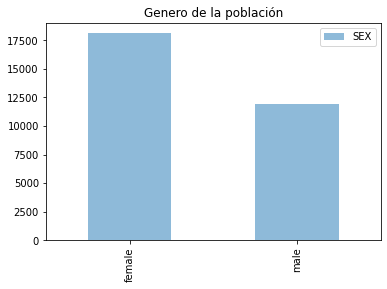

In [46]:
data.SEX.replace(enc).value_counts().plot(kind='bar',alpha=0.5)
plt.title('Genero de la población')
plt.legend()
plt.show()

Descripción de la variable educación

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable educación.

*   1 = graduate school
*   2 = university
*   3 = high school
*   4 = others





In [52]:
enc = {1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'others', 6:'others', 0:'unknown'}
data.iloc[:,2].replace(enc).value_counts()

university         14030
graduate school    10585
high school         4917
others               454
unknown               14
Name: EDUCATION, dtype: int64

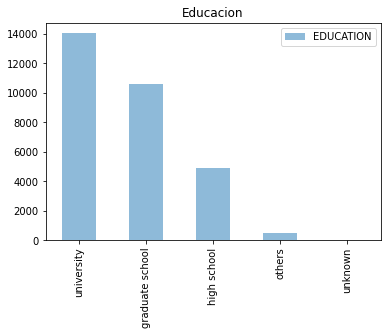

In [53]:
data.EDUCATION.replace(enc).value_counts().plot(kind='bar',alpha=0.5)
plt.title('Educacion')
plt.legend()
plt.show()

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable marriage.
*   1 = married
*   2 = single
*   3 = others






In [54]:
enc = {1:'married', 2:'single', 3:'others', 0:'unknown'}
data.iloc[:,3].replace(enc).value_counts()

single     15964
married    13659
others       323
unknown       54
Name: MARRIAGE, dtype: int64

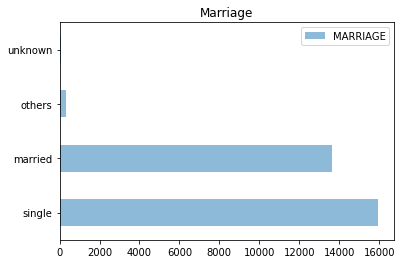

In [55]:
data.MARRIAGE.replace(enc).value_counts().plot(kind='barh',alpha=0.5)
plt.title('Marriage')
plt.legend()
plt.show()